In [12]:
import pandas as pd

df = pd.read_csv('data/DATASET_ic50_cleaned_compounds.csv')

In [13]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Generate Murcko scaffolds for each molecule
def get_murcko_scaffold(smiles):
    """Extract Murcko scaffold from SMILES string."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    except:
        return None

# Apply scaffold generation
print("Generating Murcko scaffolds...")
df['scaffold'] = df['smiles'].apply(get_murcko_scaffold)

# Filter out compounds where scaffold generation failed
df_valid = df[df['scaffold'].notna()].copy()

print(f"Compounds with valid scaffolds: {len(df_valid):,} / {len(df):,}")
print(f"Failed scaffold generation: {len(df) - len(df_valid):,}")


Generating Murcko scaffolds...
Compounds with valid scaffolds: 422 / 422
Failed scaffold generation: 0


In [15]:
from collections import Counter

# Count compounds per scaffold
scaffold_counts = Counter(df_valid['scaffold'])

print(f"Total unique scaffolds: {len(scaffold_counts):,}")
print(f"\nScaffold distribution:")
print(f"  Singletons (1 compound): {sum(1 for c in scaffold_counts.values() if c == 1):,}")
print(f"  Small series (2-5): {sum(1 for c in scaffold_counts.values() if 2 <= c <= 5):,}")
print(f"  Medium series (6-20): {sum(1 for c in scaffold_counts.values() if 6 <= c <= 20):,}")
print(f"  Large series (>20): {sum(1 for c in scaffold_counts.values() if c > 20):,}")

# Show top 10 most common scaffolds
print(f"\nTop 10 scaffolds by compound count:")
for scaffold, count in scaffold_counts.most_common(10):
    print(f"  {count:4d} compounds: {scaffold[:50]}..." if len(scaffold) > 50 else f"  {count:4d} compounds: {scaffold}")


Total unique scaffolds: 168

Scaffold distribution:
  Singletons (1 compound): 121
  Small series (2-5): 36
  Medium series (6-20): 7
  Large series (>20): 4

Top 10 scaffolds by compound count:
    50 compounds: c1ccc(-c2cc3nc(OCC45CCCN4CCC5)nc(N4CC5CCC(C4)N5)c3...
    49 compounds: c1ccc2c(-c3cc4nc(OCC56CCCN5CCC6)nc(N5CC6CCC(C5)N6)...
    31 compounds: c1ccc2c(-c3cc4ncnc(N5CC6CCC(C5)N6)c4cn3)cccc2c1
    27 compounds: c1ccc2c(-c3cc4nc(OC[C@@H]5CCCN5)nc(N5CC6CCC(C5)N6)...
     9 compounds: c1ccc(C2CC2)c(-c2cc3nc(OCC45CCCN4CCC5)nc(N4CC5CCC(...
     8 compounds: O=C1CNC(=O)C(Cc2ccccc2)NC(=O)CNC(=O)C2CCCN2C(=O)CC...
     8 compounds: c1ccc2c(-c3cc4nc(N5CCC5)nc(N5CC6CCC(C5)N6)c4cn3)cc...
     6 compounds: O=C1CNC(=O)C(Cc2ccc(-c3ccccc3)cc2)NC(=O)CNC(=O)C2C...
     6 compounds: c1cncc(CCOc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cccc5ccccc4...
     6 compounds: c1ccc(CCOc2nc(N3CC4CCC(C3)N4)c3cnc(-c4cccc5ccccc45...


In [43]:
import numpy as np

def scaffold_ic50_split(df, smiles_col='smiles', target_col = 'pIC50', test_size=0.1, val_size=0.1, n_bins = 5, random_state=42):
    """
    Perform scaffold-based train/validation/test split.
    
    All molecules sharing a scaffold are assigned to the same partition.
    Scaffolds are sorted by size (largest first) for balanced splits.

    Soft bin balancing is also done to ensure pIC50 are well distributed
    
    Returns: train_idx, val_idx, test_idx (lists of DataFrame indices)
    """
    np.random.seed(random_state)

    df['pIC50_bin'] = pd.qcut(df[target_col], q=n_bins, labels=False)
    
    # Extract scaffolds
    scaffolds = df[smiles_col].apply(get_murcko_scaffold)
    
    # Group indices by scaffold
    scaffold_to_indices = {}
    for idx, scaffold in zip(df.index, scaffolds):
        if scaffold is None:
            scaffold = f'NONE_{idx}'  # Treat parsing failures as singletons
        if scaffold not in scaffold_to_indices:
            scaffold_to_indices[scaffold] = []
        scaffold_to_indices[scaffold].append(idx)

    # Map scaffolds to their dominant bin
    scaffold_to_bin = {}
    for scaffold, indices in scaffold_to_indices.items():
        bins = df.loc[indices, 'pIC50_bin'].values
        # Dominant bin = mode
        dominant_bin = int(Counter(bins).most_common(1)[0][0])
        scaffold_to_bin[scaffold] = dominant_bin

    splits = {'train': [], 'val': [], 'test': []}
    split_targets = {
        'train': 1.0 - test_size - val_size,
        'val': val_size,
        'test': test_size
    }
    split_bin_counts = {
        'train': Counter(),
        'val': Counter(),
        'test': Counter()
    }
    split_sizes = {'train': 0, 'val': 0, 'test': 0}
    n_total = len(df)

    sorted_scaffolds = sorted(scaffold_to_indices.keys(),
                              key=lambda s: len(scaffold_to_indices[s]),
                              reverse=True)
    
    for scaffold in sorted_scaffolds:
        indices = scaffold_to_indices[scaffold]
        dominant_bin = scaffold_to_bin[scaffold]
        
        # Compute underrepresentation for this bin in each split
        underrep = {}
        for split in splits:
            target_count = split_targets[split] * n_total
            current_count = split_sizes[split]
            bin_count = split_bin_counts[split][dominant_bin]
            underrep[split] = (target_count - current_count) - bin_count
        
        # Assign scaffold to split where its bin is most underrepresented
        best_split = max(underrep, key=underrep.get)
        
        splits[best_split].extend(indices)
        split_sizes[best_split] += len(indices)
        split_bin_counts[best_split][dominant_bin] += len(indices)
    
    return splits['train'], splits['val'], splits['test']


In [44]:
# Perform scaffold-based split
train_idx, val_idx, test_idx = scaffold_ic50_split(
    df_valid,
    smiles_col='smiles',
    target_col='pIC50',
    test_size=0.1,
    val_size=0.1,
    n_bins = 5,
    random_state=42
)

# Create split DataFrames
df_train = df_valid.loc[train_idx].copy()
df_val = df_valid.loc[val_idx].copy()
df_test = df_valid.loc[test_idx].copy()

print(f"Scaffold-based split:")
print(f"  Train: {len(df_train):,} compounds ({100*len(df_train)/len(df_valid):.1f}%)")
print(f"  Val:   {len(df_val):,} compounds ({100*len(df_val)/len(df_valid):.1f}%)")
print(f"  Test:  {len(df_test):,} compounds ({100*len(df_test)/len(df_valid):.1f}%)")


Scaffold-based split:
  Train: 305 compounds (72.3%)
  Val:   59 compounds (14.0%)
  Test:  58 compounds (13.7%)


In [45]:
# Verify zero scaffold overlap
train_scaffolds = set(df_train['scaffold'])
val_scaffolds = set(df_val['scaffold'])
test_scaffolds = set(df_test['scaffold'])

train_val_overlap = train_scaffolds.intersection(val_scaffolds)
train_test_overlap = train_scaffolds.intersection(test_scaffolds)
val_test_overlap = val_scaffolds.intersection(test_scaffolds)

print("Scaffold Overlap Verification:")
print(f"  Train-Val overlap: {len(train_val_overlap)} scaffolds")
print(f"  Train-Test overlap: {len(train_test_overlap)} scaffolds")
print(f"  Val-Test overlap: {len(val_test_overlap)} scaffolds")

if len(train_val_overlap) == 0 and len(train_test_overlap) == 0 and len(val_test_overlap) == 0:
    print("\n[SUCCESS] Zero scaffold overlap - split integrity verified!")
else:
    print("\n[ERROR] Scaffold overlap detected - check implementation!")


Scaffold Overlap Verification:
  Train-Val overlap: 0 scaffolds
  Train-Test overlap: 0 scaffolds
  Val-Test overlap: 0 scaffolds

[SUCCESS] Zero scaffold overlap - split integrity verified!


In [46]:
# Analyze pIC50 distributions across splits
print("pIC50 Distribution Analysis:")
print(f"{'Partition':<10} {'Count':>8} {'Mean':>8} {'Std':>8} {'Min':>8} {'Max':>8}")
print("-" * 58)

for name, data in [('Train', df_train), ('Val', df_val), ('Test', df_test)]:
    print(f"{name:<10} {len(data):>8,} {data['pIC50'].mean():>8.2f} {data['pIC50'].std():>8.2f} {data['pIC50'].min():>8.2f} {data['pIC50'].max():>8.2f}")

print("-" * 58)
print(f"{'Total':<10} {len(df_valid):>8,} {df_valid['pIC50'].mean():>8.2f} {df_valid['pIC50'].std():>8.2f} {df_valid['pIC50'].min():>8.2f} {df_valid['pIC50'].max():>8.2f}")


pIC50 Distribution Analysis:
Partition     Count     Mean      Std      Min      Max
----------------------------------------------------------
Train           305     6.37     1.09     4.41     9.70
Val              59     7.00     1.16     4.69     9.07
Test             58     7.14     1.28     4.69     9.15
----------------------------------------------------------
Total           422     6.57     1.17     4.41     9.70


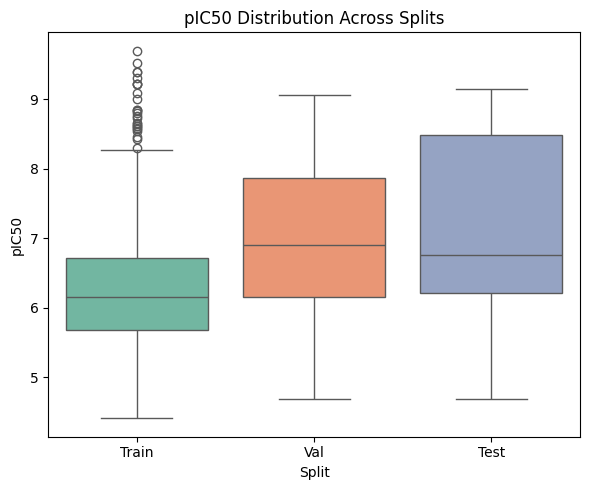

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine data with labels
df_train['Split'] = 'Train'
df_val['Split'] = 'Val'
df_test['Split'] = 'Test'
df_combined = pd.concat([df_train, df_val, df_test])

# Box plot
plt.figure(figsize=(6, 5))
sns.boxplot(data=df_combined, x='Split', y='pIC50', hue='Split',
            order=['Train', 'Val', 'Test'], palette='Set2', legend=False)
plt.title('pIC50 Distribution Across Splits')
plt.tight_layout()
plt.show()


In [48]:
# Create index mapping from SMILES to row position

df_ecfp4_final = pd.read_csv("data/DATASET_ecfp4.csv")
df_maccs_final = pd.read_csv("data/DATASET_maccs.csv")
df_rdkit_final = pd.read_csv("data/DATASET_rdkit.csv")
df_fingerprints_combined = pd.read_csv("data/DATASET_fp_combined.csv")

smiles_to_split = {}
for idx in train_idx:
    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'train'
for idx in val_idx:
    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'val'
for idx in test_idx:
    smiles_to_split[df_valid.loc[idx, 'smiles']] = 'test'
 
def split_by_smiles(df, smiles_col='smiles'):
    """Split DataFrame using SMILES-based assignment."""
    df['split'] = df[smiles_col].map(smiles_to_split)
    train = df[df['split'] == 'train'].drop(columns=['split'])
    val = df[df['split'] == 'val'].drop(columns=['split'])
    test = df[df['split'] == 'test'].drop(columns=['split'])
    return train, val, test
 
# Split all fingerprint datasets
fp_ecfp4_train, fp_ecfp4_val, fp_ecfp4_test = split_by_smiles(df_ecfp4_final)
fp_maccs_train, fp_maccs_val, fp_maccs_test = split_by_smiles(df_maccs_final)
fp_rdkit_train, fp_rdkit_val, fp_rdkit_test = split_by_smiles(df_rdkit_final)
fp_combined_train, fp_combined_val, fp_combined_test = split_by_smiles(df_fingerprints_combined)
 
print(f"ECFP4 split: train={len(fp_ecfp4_train)}, val={len(fp_ecfp4_val)}, test={len(fp_ecfp4_test)}")
print(f"MACCS split: train={len(fp_maccs_train)}, val={len(fp_maccs_val)}, test={len(fp_maccs_test)}")
print(f"RDKIT split: train={len(fp_rdkit_train)}, val={len(fp_rdkit_val)}, test={len(fp_rdkit_test)}")
print(f"Combined FP split: train={len(fp_combined_train)}, val={len(fp_combined_val)}, test={len(fp_combined_test)}")

ECFP4 split: train=305, val=59, test=58
MACCS split: train=305, val=59, test=58
RDKIT split: train=305, val=59, test=58
Combined FP split: train=305, val=59, test=58


In [49]:
# Split descriptor dataset
df_descriptors = pd.read_csv("data/DATASET_descriptors.csv")
desc_train, desc_val, desc_test = split_by_smiles(df_descriptors)
print(f"Descriptor split: train={len(desc_train)}, val={len(desc_val)}, test={len(desc_test)}")

Descriptor split: train=305, val=59, test=58


In [ ]:
import os

# Create splits directory
os.makedirs('splits', exist_ok=True)

# Save ECFP4 splits
fp_ecfp4_train.to_csv('splits/DATASET_ecfp4_train.csv', index=False)
fp_ecfp4_val.to_csv('splits/DATASET_ecfp4_val.csv', index=False)
fp_ecfp4_test.to_csv('splits/DATASET_ecfp4_test.csv', index=False)

# Save MACCS splits
fp_maccs_train.to_csv('splits/DATASET_maccs_train.csv', index=False)
fp_maccs_val.to_csv('splits/DATASET_maccs_val.csv', index=False)
fp_maccs_test.to_csv('splits/DATASET_maccs_test.csv', index=False)

# Save RDKit fingerprint splits
fp_rdkit_train.to_csv('splits/DATASET_rdkit_fp_train.csv', index=False)
fp_rdkit_val.to_csv('splits/DATASET_rdkit_fp_val.csv', index=False)
fp_rdkit_test.to_csv('splits/DATASET_rdkit_fp_test.csv', index=False)

# Save combined fingerprint splits
fp_combined_train.to_csv('splits/DATASET_fingerprints_combined_train.csv', index=False)
fp_combined_val.to_csv('splits/DATASET_fingerprints_combined_val.csv', index=False)
fp_combined_test.to_csv('splits/DATASET_fingerprints_combined_test.csv', index=False)

# Save descriptor splits
desc_train.to_csv('splits/DATASET_descriptors_train.csv', index=False)
desc_val.to_csv('splits/DATASET_descriptors_val.csv', index=False)
desc_test.to_csv('splits/DATASET_descriptors_test.csv', index=False)

print("All split datasets saved to 'splits/' directory")
print(f"Files created: {len(os.listdir('splits'))}")



ECFP4:
  Feature columns: 2048
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 305, Val: 59, Test: 58

MACCS:
  Feature columns: 167
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 305, Val: 59, Test: 58

RDKit Fingerprints:
  Feature columns: 2048
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 305, Val: 59, Test: 58

Combined Fingerprints:
  Feature columns: 4263
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 305, Val: 59, Test: 58

Descriptors:
  Feature columns: 89
  Excluded columns: ['molecule_chembl_id', 'smiles', 'pIC50']
  Train: 305, Val: 59, Test: 58


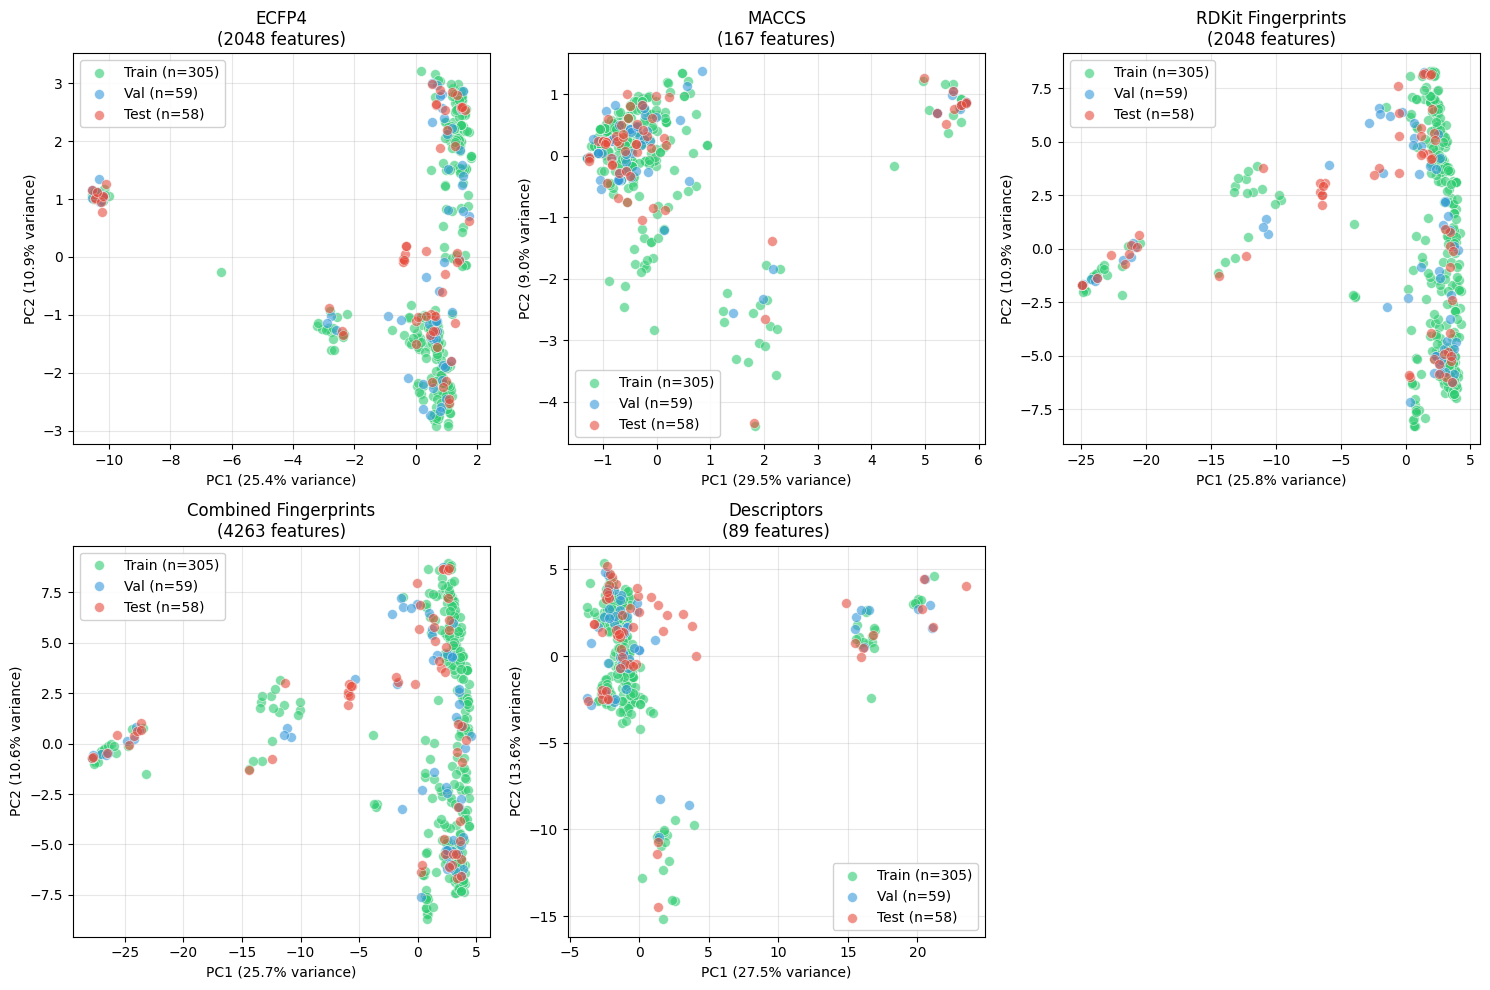

In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the 5 methods and their file prefixes
methods = {
    'ECFP4': 'DATASET_ecfp4',
    'MACCS': 'DATASET_maccs',
    'RDKit Fingerprints': 'DATASET_rdkit_fp',
    'Combined Fingerprints': 'DATASET_fingerprints_combined',
    'Descriptors': 'DATASET_descriptors'
}

# Columns to exclude (non-feature columns)
EXCLUDE_COLS = ['molecule_chembl_id', 'smiles', 'pIC50']

def detect_feature_columns(df):
    """
    Detect feature columns by excluding specified non-feature columns.
    """
    non_feature_cols = [col for col in df.columns if col in EXCLUDE_COLS]
    feature_cols = [col for col in df.columns if col not in EXCLUDE_COLS]
    return feature_cols, non_feature_cols

def load_splits(file_prefix, splits_dir='splits'):
    """
    Load train, validation, and test splits for a given method.
    """
    train_df = pd.read_csv(f'{splits_dir}/{file_prefix}_train.csv')
    val_df = pd.read_csv(f'{splits_dir}/{file_prefix}_val.csv')
    test_df = pd.read_csv(f'{splits_dir}/{file_prefix}_test.csv')
    return train_df, val_df, test_df

def plot_pca_for_method(method_name, file_prefix, splits_dir='splits', ax=None):
    """
    Perform PCA and plot for train/val/test subsets of a given method.
    """
    # Load data
    train_df, val_df, test_df = load_splits(file_prefix, splits_dir)

    # Detect feature columns
    feature_cols, non_feature_cols = detect_feature_columns(train_df)

    print(f"\n{method_name}:")
    print(f"  Feature columns: {len(feature_cols)}")
    print(f"  Excluded columns: {non_feature_cols}")
    print(f"  Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

    # Extract features
    X_train = train_df[feature_cols].values.astype(float)
    X_val = val_df[feature_cols].values.astype(float)
    X_test = test_df[feature_cols].values.astype(float)

    # Only scale for Descriptors
    if method_name == 'Descriptors':
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

    # Perform PCA (fit on train, transform all)
    pca = PCA(n_components=2)
    train_pca = pca.fit_transform(X_train)
    val_pca = pca.transform(X_val)
    test_pca = pca.transform(X_test)

    # Get explained variance
    var_explained = pca.explained_variance_ratio_ * 100

    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    ax.scatter(train_pca[:, 0], train_pca[:, 1], alpha=0.6, label=f'Train (n={len(train_df)})',
               c='#2ecc71', edgecolors='white', linewidth=0.5, s=50)
    ax.scatter(val_pca[:, 0], val_pca[:, 1], alpha=0.6, label=f'Val (n={len(val_df)})',
               c='#3498db', edgecolors='white', linewidth=0.5, s=50)
    ax.scatter(test_pca[:, 0], test_pca[:, 1], alpha=0.6, label=f'Test (n={len(test_df)})',
               c='#e74c3c', edgecolors='white', linewidth=0.5, s=50)

    ax.set_xlabel(f'PC1 ({var_explained[0]:.1f}% variance)')
    ax.set_ylabel(f'PC2 ({var_explained[1]:.1f}% variance)')
    ax.set_title(f'{method_name}\n({len(feature_cols)} features)')
    ax.legend(loc='best', framealpha=0.9)
    ax.grid(True, alpha=0.3)

    return pca, var_explained

# Main execution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (method_name, file_prefix) in enumerate(methods.items()):
    plot_pca_for_method(method_name, file_prefix, splits_dir='splits', ax=axes[idx])

# Hide the 6th subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(y_true, y_pred, set_name=''):
    """
    Calculate and display regression metrics.
    
    Returns dict with R², RMSE, and MAE.
    """
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    metrics = {'R2': r2, 'RMSE': rmse, 'MAE': mae}
    
    if set_name:
        print(f"{set_name:15} R²={r2:.3f}  RMSE={rmse:.3f}  MAE={mae:.3f}")
    
    return metrics

In [2]:
#feature selection

import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_regression

fp_ecfp4_train = pd.read_csv("splits/DATASET_ecfp4_train.csv")
fp_ecfp4_val = pd.read_csv("splits/DATASET_ecfp4_val.csv")
fp_ecfp4_test = pd.read_csv("splits/DATASET_ecfp4_test.csv")
fp_maccs_train = pd.read_csv("splits/DATASET_maccs_train.csv")
fp_maccs_val = pd.read_csv("splits/DATASET_maccs_val.csv")
fp_maccs_test = pd.read_csv("splits/DATASET_maccs_test.csv")
fp_rdkit_train = pd.read_csv("splits/DATASET_rdkit_fp_train.csv")
fp_rdkit_val = pd.read_csv("splits/DATASET_rdkit_fp_val.csv")
fp_rdkit_test = pd.read_csv("splits/DATASET_rdkit_fp_test.csv")
desc_train = pd.read_csv("splits/DATASET_descriptors_train.csv")
desc_val = pd.read_csv("splits/DATASET_descriptors_val.csv")
desc_test = pd.read_csv("splits/DATASET_descriptors_test.csv")
fp_combined_train = pd.read_csv("splits/DATASET_fingerprints_combined_train.csv")
fp_combined_val = pd.read_csv("splits/DATASET_fingerprints_combined_val.csv")
fp_combined_test = pd.read_csv("splits/DATASET_fingerprints_combined_test.csv")

feature_groups = {
    "ECFP4": (fp_ecfp4_train, fp_ecfp4_val, fp_ecfp4_test),
    "MACCS": (fp_maccs_train, fp_maccs_val, fp_maccs_test),
    "RDKit": (fp_rdkit_train, fp_rdkit_val, fp_rdkit_test),
    "Descriptors": (desc_train, desc_val, desc_test),
    "CombinedFP": (fp_combined_train, fp_combined_val, fp_combined_test)
}


In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

# -----------------------------
# RF feature selection for fingerprints
# -----------------------------
def feature_selection_rf(train_df, target_col='pIC50',
                         metadata_cols=['molecule_chembl_id', 'smiles', 'pIC50'],
                         random_state=42):
    feature_cols = [c for c in train_df.columns if c not in metadata_cols]

    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values

    # Train RF to get feature importance
    rf = RandomForestRegressor(n_estimators=200, random_state=random_state, n_jobs=-1)
    rf.fit(X_train, y_train)

    importances = rf.feature_importances_
    ranked_idx = np.argsort(importances)[::-1]
    ranked_features = np.array(feature_cols)[ranked_idx]

    # Select top 10% or at least 20 features
    top_n = max(20, int(0.1 * len(ranked_features)))
    selected_feats = ranked_features[:top_n]
    print(f"RF: Selected top {top_n} features based on importance.")

    # Optional RFECV to refine
    #rf_rfe = RandomForestRegressor(n_estimators=100, random_state=random_state, n_jobs=-1)
    #rfecv = RFECV(rf_rfe, step=5, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    #rfecv.fit(X_train[:, ranked_idx[:top_n]], y_train)

    #final_feats = selected_feats[rfecv.support_]
    #print(f"RF: RFECV selected {len(final_feats)} features.")

    return list(selected_feats)

# -----------------------------
# LASSO feature selection for descriptors
# -----------------------------
def feature_selection_lasso(train_df, target_col='pIC50',
                            metadata_cols=['molecule_chembl_id', 'smiles', 'pIC50'],
                            random_state=42):
    feature_cols = [c for c in train_df.columns if c not in metadata_cols]

    X_train = train_df[feature_cols].values
    y_train = train_df[target_col].values

    # Build pipeline: scale -> LASSO selection
    lasso = LassoCV(cv=5, random_state=random_state, n_jobs=-1, max_iter=20000)
    selector = SelectFromModel(lasso, prefit=False)  # will fit inside pipeline

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selector', selector)
    ])

    # Fit pipeline on training data
    pipeline.fit(X_train, y_train)

    # Get selected feature names
    mask = pipeline.named_steps['feature_selector'].get_support()
    selected_feats = np.array(feature_cols)[mask]
    print(f"LASSO: Selected {len(selected_feats)} features.")

    return pipeline, list(selected_feats), feature_cols

# -----------------------------
# Apply feature selection to all groups
# -----------------------------
selected_features = {}
scalers = {}  # for descriptors

for name, (train_df, val_df, test_df) in feature_groups.items():
    print(f"\n=== Feature selection for {name} ===")
    if name == 'Descriptors':
        scaler, feats, all_cols = feature_selection_lasso(train_df)
        selected_features[name] = all_cols
        scalers[name] = scaler
    else:
        feats = feature_selection_rf(train_df)
        selected_features[name] = feats



=== Feature selection for ECFP4 ===
RF: Selected top 204 features based on importance.

=== Feature selection for MACCS ===
RF: Selected top 20 features based on importance.

=== Feature selection for RDKit ===
RF: Selected top 204 features based on importance.

=== Feature selection for Descriptors ===
LASSO: Selected 29 features.

=== Feature selection for CombinedFP ===
RF: Selected top 426 features based on importance.


In [6]:
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# -----------------------------
# Function to prepare X matrices for baseline model
# -----------------------------
def prepare_X(df, selected_feats, scaler=None):
    if scaler is not None:
        X = scaler.transform(df[selected_feats].values)
    else:
        X = df[selected_feats].values
    return X

# -----------------------------
# Train baseline models  on train set and evaluate
# -----------------------------
results = {}

models_dict = {
    "RF": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "SVR": SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale'),
    "XGB": XGBRegressor(n_estimators=100,learning_rate=0.1,max_depth=3,subsample=1.0,colsample_bytree=1.0,reg_lambda=0.0,reg_alpha=1.0,objective="reg:squarederror",random_state=42,n_jobs=-1),
    "LightGBM": LGBMRegressor(n_estimators=100,learning_rate=0.1,num_leaves=31,random_state=42,n_jobs=-1,importance_type='gain', verbose=-1)
}

for model in models_dict:
    print(f"\n=== Baseline {model} model ===")
    baseline = models_dict[model]

    for name, (train_df, val_df, test_df) in feature_groups.items():
        print(f"Running Baseline Model for : {name}")
        feats = selected_features[name]
        scaler = scalers.get(name, None)

        X_train = prepare_X(train_df, feats, scaler)
        y_train = train_df['pIC50'].values

        X_val = prepare_X(val_df, feats, scaler)
        y_val = val_df['pIC50'].values
        
        # Train baseline
        baseline = models_dict[model]
        baseline.fit(X_train, y_train)

        results[f'{model}_{name}_baseline_train'] = evaluate_model(
            y_train, baseline.predict(X_train), 'Train')
        results[f'{model}_{name}_baseline_val'] = evaluate_model(
            y_val, baseline.predict(X_val), 'Val')
        
        


=== Baseline RF model ===
Running Baseline Model for : ECFP4
Train           R²=0.948  RMSE=0.247  MAE=0.179
Val             R²=0.412  RMSE=0.884  MAE=0.666
Running Baseline Model for : MACCS
Train           R²=0.784  RMSE=0.505  MAE=0.354
Val             R²=0.291  RMSE=0.971  MAE=0.760
Running Baseline Model for : RDKit
Train           R²=0.951  RMSE=0.240  MAE=0.177
Val             R²=0.586  RMSE=0.742  MAE=0.588
Running Baseline Model for : Descriptors
Train           R²=0.948  RMSE=0.248  MAE=0.185
Val             R²=0.399  RMSE=0.894  MAE=0.704
Running Baseline Model for : CombinedFP
Train           R²=0.954  RMSE=0.234  MAE=0.173
Val             R²=0.540  RMSE=0.782  MAE=0.604

=== Baseline SVR model ===
Running Baseline Model for : ECFP4
Train           R²=0.860  RMSE=0.407  MAE=0.281
Val             R²=0.302  RMSE=0.964  MAE=0.748
Running Baseline Model for : MACCS
Train           R²=0.699  RMSE=0.596  MAE=0.406
Val             R²=0.258  RMSE=0.994  MAE=0.799
Running Baseline 

In [7]:
import math
from sklearn.model_selection import GridSearchCV

def grid_search_best_performing(model, feat, feature_groups):

    feats = selected_features[feat]
    scaler = scalers.get(feat, None)

    X_train = prepare_X(feature_groups[feat][0], feats, scaler)
    y_train = feature_groups[feat][0]['pIC50'].values

    X_val = prepare_X(feature_groups[feat][1], feats, scaler)
    y_val = feature_groups[feat][1]['pIC50'].values

    if model == "RF":
        # Define the search space
        param_grid = {
            'n_estimators': [200, 400],          # Enough trees for stability
            'max_depth': [12, 20, None],         # Shallow, medium, unlimited
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2],
            'max_features': ['sqrt']             # log2 rarely better; cuts runtime
        }

        estimator = RandomForestRegressor(random_state=42, n_jobs=-1)

    elif model == "XGB":
        param_grid = {
            "n_estimators": [400, 800, 1200],    # Fewer but still expressive
            "max_depth": [3, 5],                 # Avoid very deep trees
            "learning_rate": [0.03, 0.07],
            "subsample": [0.7, 1.0],
            "colsample_bytree": [0.5, 0.8]
        }

        estimator = XGBRegressor(random_state=42, n_jobs=-1,objective='reg:squarederror')
    
    elif model == "LightGBM":
        param_grid = param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.03, 0.07],
            'num_leaves': [31, 63],              # Main complexity control
            'min_data_in_leaf': [10, 20],
            'lambda_l1': [0.0, 0.5],
            'lambda_l2': [0.0, 0.5]
        }

        estimator=LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)

    elif model == "SVR":
        # Define the search space
        param_grid = {
            'C': [0.1, 1.0, 10.0, 100.0],           # Regularization (higher = less regularization)
            'gamma': ['scale', 'auto', 0.01, 0.1],  # Kernel coefficient
            'epsilon': [0.01, 0.1, 0.2, 0.5]        # Epsilon-tube width
        }

        estimator = SVR(kernel='rbf')
    
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        cv=5,                              # 5-fold cross-validation
        scoring='neg_mean_squared_error',  # Minimize MSE
        n_jobs=-1,                         # Parallel processing
        return_train_score=True,           # Track overfitting
        verbose=0                          # Hide progress
    )

    n_combinations = math.prod(len(v) for v in param_grid.values())

    print(f"{model} parameter grid:")
    for param, values in param_grid.items():
        print(f"  {param}: {values}")
    print(f"\nTotal combinations: {n_combinations}")
    print(f"Total fits (with 5-fold CV): {n_combinations * 5}")
    
    # Fit to your training data
    grid_search.fit(X_train, y_train)

    print(f"\nBest parameters found:")
    for param, value in grid_search.best_params_.items():
        print(f"  {param}: {value}")

    return grid_search, X_train, y_train, X_val, y_val

In [9]:
# optimise RF, XGB and LightGBM on RDKit

for model in ["RF", "XGB", "LightGBM"]:
    print(f"\n=== Optimised {model} model ===")

    grid_search, X_train, y_train, X_val, y_val = grid_search_best_performing(model, "RDKit", feature_groups)
    optimized_model = grid_search.best_estimator_

    # Convert cv_results_ to a DataFrame for easier handling
    cv_results = pd.DataFrame(grid_search.cv_results_)

    # Calculate mean CV RMSE (mean_test_score is used for validation folds)
    cv_results['mean_cv_rmse'] = np.sqrt(abs(cv_results['mean_test_score']))

    # Calculate mean Train RMSE
    cv_results['mean_train_rmse'] = np.sqrt(abs(cv_results['mean_train_score']))

    print(f"\nCV and training RMSE:")
    print(cv_results[['mean_cv_rmse', 'mean_train_rmse']])

    results[f'{model}_RDKit_optimized_train'] = evaluate_model(
        y_train, optimized_model.predict(X_train), 'Train')
    results[f'{model}_RDKit_optimized_val'] = evaluate_model(
        y_val, optimized_model.predict(X_val), 'Val')

    # Compare with baseline
    baseline_val_r2 = results[f'{model}_RDKit_baseline_val']['R2']
    optimized_val_r2 = results[f'{model}_RDKit_optimized_val']['R2']
    improvement = optimized_val_r2 - baseline_val_r2
 
    print(f"\nImprovement over baseline:")
    print(f"  Baseline Val R²:  {baseline_val_r2:.4f}")
    print(f"  Optimized Val R²: {optimized_val_r2:.4f}")
    print(f"  Improvement:       {improvement:+.4f}")


=== Optimised RF model ===
RF parameter grid:
  n_estimators: [200, 400]
  max_depth: [12, 20, None]
  min_samples_split: [2, 5]
  min_samples_leaf: [1, 2]
  max_features: ['sqrt']

Total combinations: 24
Total fits (with 5-fold CV): 120



Best parameters found:
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 1
  min_samples_split: 2
  n_estimators: 400

CV and training RMSE:
    mean_cv_rmse  mean_train_rmse
0       0.678920         0.255799
1       0.675047         0.253154
2       0.677287         0.332462
3       0.673752         0.331511
4       0.690423         0.402875
5       0.682132         0.399983
6       0.684034         0.409348
7       0.681369         0.407639
8       0.671793         0.234831
9       0.668732         0.233234
10      0.674108         0.328018
11      0.674863         0.326110
12      0.681369         0.401224
13      0.679786         0.399561
14      0.682747         0.409344
15      0.681783         0.407525
16      0.670171         0.234893
17      0.667763         0.233069
18      0.675566         0.328192
19      0.676128         0.326271
20      0.681458         0.401209
21      0.679829         0.399554
22      0.682747         0.409344
23      0.681783         0.407525

In [10]:
# explore fingerprint + descriptors model (redo feature selection on concatenated features)

scaler = StandardScaler()

metadata_cols=['molecule_chembl_id', 'smiles', 'pIC50']
target_col = "pIC50"
desc_feature_cols = [c for c in desc_train.columns if c not in metadata_cols]
fp_feature_cols = [c for c in fp_rdkit_train.columns if c not in metadata_cols]


X_desc_train = desc_train[desc_feature_cols].values
y_desc_train = desc_train[target_col].values
X_desc_val = desc_val[desc_feature_cols].values
y_desc_val = desc_val[target_col].values

desc_train_scaled = scaler.fit_transform(X_desc_train)
desc_val_scaled   = scaler.transform(X_desc_val)

desc_train_scaled = pd.DataFrame(
    desc_train_scaled, 
    columns=desc_feature_cols
)

desc_val_scaled = pd.DataFrame(
    desc_val_scaled, 
    columns=desc_feature_cols
)

desc_train_scaled = pd.DataFrame(
    desc_train_scaled, 
    columns=desc_feature_cols
)

X_fp_rdkit_train = pd.DataFrame(
    fp_rdkit_train[fp_feature_cols].values, 
    columns=fp_feature_cols
)

X_fp_rdkit_val = pd.DataFrame(
    fp_rdkit_val[fp_feature_cols].values, 
    columns=fp_feature_cols
)


X_train = pd.concat([X_fp_rdkit_train, desc_train_scaled], axis=1)
X_val   = pd.concat([X_fp_rdkit_val,   desc_val_scaled],   axis=1)

print("Combined feature shape:", X_train.shape)

Combined feature shape: (305, 2137)


In [11]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression

#remove near constant features (previously only done for descriptors and not fingerprint)
var_thresh = VarianceThreshold(threshold=0.0)

X_train_var = var_thresh.fit_transform(X_train)
X_val_var   = var_thresh.transform(X_val)

selected_var_cols = X_train.columns[var_thresh.get_support()]

X_train_var = pd.DataFrame(
    X_train_var,
    columns=selected_var_cols,
    index=X_train.index
)

X_val_var = pd.DataFrame(
    X_val_var,
    columns=selected_var_cols,
    index=X_val.index
)

print("After variance threshold:", X_train_var.shape)

After variance threshold: (305, 2087)


In [12]:
#find best combination of number of features with model

import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

k_results = []

k_grid = [20, 40, 60, 80]

for k in tqdm(k_grid, desc="Feature count (k)"):

    # ----------------------------
    # Feature selection
    # ----------------------------
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_k = selector.fit_transform(X_train_var, y_desc_train)
    X_val_k   = selector.transform(X_val_var)

    # ----------------------------
    # Tree-based models (no scaling)
    # ----------------------------
    for name, model in models_dict.items():
        model.fit(X_train_k, y_desc_train)
        y_pred = model.predict(X_val_k)

        k_results.append({
            "model": name,
            "k": k,
            "r2": r2_score(y_desc_val, y_pred),
            "rmse": np.sqrt(mean_squared_error(y_desc_val, y_pred))
        })


Feature count (k): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]


In [13]:
results_sorted = sorted(k_results, key=lambda x: x["r2"], reverse=True)
for r in results_sorted:
    print(r)

{'model': 'SVR', 'k': 80, 'r2': 0.5875808637114386, 'rmse': 0.7407080714025464}
{'model': 'LightGBM', 'k': 80, 'r2': 0.5655532140184454, 'rmse': 0.7602316868732583}
{'model': 'SVR', 'k': 60, 'r2': 0.533653839177493, 'rmse': 0.7876474581895295}
{'model': 'LightGBM', 'k': 40, 'r2': 0.528236495158164, 'rmse': 0.7922091306196364}
{'model': 'LightGBM', 'k': 60, 'r2': 0.5225871100204725, 'rmse': 0.7969383811010373}
{'model': 'RF', 'k': 80, 'r2': 0.5167619626769477, 'rmse': 0.8017855570334771}
{'model': 'RF', 'k': 60, 'r2': 0.5045154555922292, 'rmse': 0.8118816562289656}
{'model': 'XGB', 'k': 80, 'r2': 0.47779170482782163, 'rmse': 0.8334883925067791}
{'model': 'XGB', 'k': 40, 'r2': 0.4688733582508384, 'rmse': 0.8405754779349673}
{'model': 'XGB', 'k': 60, 'r2': 0.46659789640501603, 'rmse': 0.8423741574326995}
{'model': 'RF', 'k': 40, 'r2': 0.4624259842252616, 'rmse': 0.8456619829605397}
{'model': 'SVR', 'k': 40, 'r2': 0.45756209733924147, 'rmse': 0.8494790779582396}
{'model': 'LightGBM', 'k': 

In [14]:
# get top 80 features for RDKit_Descriptors SVR model

selector = SelectKBest(score_func=f_regression, k=80)
X_train_k = selector.fit_transform(X_train_var, y_desc_train)
X_val_k = selector.transform(X_val_var)
selected_columns = X_train_var.columns[selector.get_support()]

In [15]:
selected_features["RDKit_Descriptors"] = selected_columns.tolist()

In [16]:
print(f"\n=== Baseline RDKit_Descriptors model ===")

# Train baseline
baseline = models_dict["SVR"]
baseline.fit(X_train_k, y_desc_train)

results['SVR_RDKit_Descriptors_baseline_train'] = evaluate_model(
    y_desc_train, baseline.predict(X_train_k), 'Train')
results['SVR_RDKit_Descriptors_baseline_val'] = evaluate_model(
    y_val, baseline.predict(X_val_k), 'Val')


=== Baseline RDKit_Descriptors model ===
Train           R²=0.720  RMSE=0.576  MAE=0.404
Val             R²=0.588  RMSE=0.741  MAE=0.605


In [17]:
print(f"\n=== Optimised RDKit_Descriptors model ===")

param_grid = {
    'C': [0.1, 1.0, 10.0, 100.0],           # Regularization (higher = less regularization)
    'gamma': ['scale', 'auto', 0.01, 0.1],  # Kernel coefficient
    'epsilon': [0.01, 0.1, 0.2, 0.5]        # Epsilon-tube width
}

estimator = SVR(kernel='rbf')

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    cv=5,                              # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # Minimize MSE
    n_jobs=-1,                         # Parallel processing
    return_train_score=True,           # Track overfitting
    verbose=0                          # Hide progress
)

n_combinations = math.prod(len(v) for v in param_grid.values())

print(f"{model} parameter grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nTotal combinations: {n_combinations}")
print(f"Total fits (with 5-fold CV): {n_combinations * 5}")

# Fit to your training data
grid_search.fit(X_train_k, y_desc_train)

print(f"\nBest parameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

optimized_model = grid_search.best_estimator_

# Convert cv_results_ to a DataFrame for easier handling
cv_results = pd.DataFrame(grid_search.cv_results_)

# Calculate mean CV RMSE (mean_test_score is used for validation folds)
cv_results['mean_cv_rmse'] = np.sqrt(abs(cv_results['mean_test_score']))

# Calculate mean Train RMSE
cv_results['mean_train_rmse'] = np.sqrt(abs(cv_results['mean_train_score']))

print(f"\nCV and training RMSE:")
print(cv_results[['mean_cv_rmse', 'mean_train_rmse']])

results[f'SVR_RDKit_Descriptors_optimized_train'] = evaluate_model(
    y_desc_train, optimized_model.predict(X_train_k), 'Train')
results[f'SVR_RDKit_Descriptors_optimized_val'] = evaluate_model(
    y_val, optimized_model.predict(X_val_k), 'Val')

# Compare with baseline
baseline_val_r2 = results[f'SVR_RDKit_Descriptors_baseline_val']['R2']
optimized_val_r2 = results[f'SVR_RDKit_Descriptors_optimized_val']['R2']
improvement = optimized_val_r2 - baseline_val_r2

print(f"\nImprovement over baseline:")
print(f"  Baseline Val R²:  {baseline_val_r2:.4f}")
print(f"  Optimized Val R²: {optimized_val_r2:.4f}")
print(f"  Improvement:       {improvement:+.4f}")


=== Optimised RDKit_Descriptors model ===
LGBMRegressor(importance_type='gain', n_jobs=-1, random_state=42, verbose=-1) parameter grid:
  C: [0.1, 1.0, 10.0, 100.0]
  gamma: ['scale', 'auto', 0.01, 0.1]
  epsilon: [0.01, 0.1, 0.2, 0.5]

Total combinations: 64
Total fits (with 5-fold CV): 320

Best parameters found:
  C: 10.0
  epsilon: 0.5
  gamma: auto

CV and training RMSE:
    mean_cv_rmse  mean_train_rmse
0       0.985468         0.838072
1       0.960179         0.868745
2       0.959541         0.879786
3       1.017704         0.853998
4       0.985037         0.841178
..           ...              ...
59      0.928844         0.320548
60      0.867435         0.457698
61      0.798132         0.496860
62      0.770634         0.505786
63      0.911111         0.428766

[64 rows x 2 columns]
Train           R²=0.735  RMSE=0.560  MAE=0.427
Val             R²=0.682  RMSE=0.650  MAE=0.531

Improvement over baseline:
  Baseline Val R²:  0.5876
  Optimized Val R²: 0.6825
  Improveme

In [18]:
# Create comprehensive summary table
summary_data = []
 
model_configs = [
    ('Random Forest (RDKit FP) - Baseline', 'RF_RDKit_baseline'),
    ('Random Forest (RDKit FP) - Optimized', 'RF_RDKit_optimized'),
    ('XGB (RDKit FP) - Baseline', 'XGB_RDKit_baseline'),
    ('XGB (RDKit FP) - Optimized', 'XGB_RDKit_optimized'),
    ('LightGBM (RDKit FP) - Baseline', 'LightGBM_RDKit_baseline'),
    ('LightGBM (RDKit FP) - Optimized', 'LightGBM_RDKit_optimized'),
    ('SVR (RDKit FP and Descriptors) - Baseline', 'SVR_RDKit_Descriptors_baseline'),
    ('SVR (RDKit FP and Descriptors) - Optimized', 'SVR_RDKit_Descriptors_optimized')
]

for name, prefix in model_configs:
    if f'{prefix}_val' in results:
        summary_data.append({
            'Model': name,
            'Train R²': results[f'{prefix}_train']['R2'],
            'Val R²': results[f'{prefix}_val']['R2'],
            'Val RMSE': results[f'{prefix}_val']['RMSE'],
            'Val MAE': results[f'{prefix}_val']['MAE'],
        })
 
df_summary = pd.DataFrame(summary_data)
 
print("=" * 90)
print("MODEL COMPARISON SUMMARY")
print("=" * 90)
print(df_summary.to_string(index=False))
print("=" * 90)


MODEL COMPARISON SUMMARY
                                     Model  Train R²   Val R²  Val RMSE  Val MAE
       Random Forest (RDKit FP) - Baseline  0.951402 0.585888  0.742227 0.588118
      Random Forest (RDKit FP) - Optimized  0.955834 0.578889  0.748473 0.598898
                 XGB (RDKit FP) - Baseline  0.904998 0.529999  0.790728 0.629363
                XGB (RDKit FP) - Optimized  0.930087 0.565786  0.760028 0.619078
            LightGBM (RDKit FP) - Baseline  0.924282 0.516952  0.801628 0.650603
           LightGBM (RDKit FP) - Optimized  0.919238 0.558852  0.766073 0.618332
 SVR (RDKit FP and Descriptors) - Baseline  0.719694 0.587581  0.740708 0.604852
SVR (RDKit FP and Descriptors) - Optimized  0.734861 0.682471  0.649934 0.530807


In [33]:
import os

os.makedirs('reports', exist_ok=True)
os.makedirs('models', exist_ok=True)

In [35]:
import joblib
import os
 
# Save Random Forest models
joblib.dump(rf_baseline, 'models/rf_baseline.joblib')
joblib.dump(rf_optimized, 'models/rf_optimized.joblib')
 
# Save SVR models
joblib.dump(svr_baseline, 'models/svr_baseline.joblib')
joblib.dump(svr_optimized, 'models/svr_optimized.joblib')
 
# Save GridSearchCV objects (contains full search history)
joblib.dump(rf_grid_search, 'models/rf_gridsearch_cv.joblib')
joblib.dump(svr_grid_search, 'models/svr_gridsearch_cv.joblib')
 
print("All models saved to 'models/' directory:")
for f in sorted(os.listdir('models')):
    print(f"  {f}")


All models saved to 'models/' directory:
  .DS_Store
  rf_baseline.joblib
  rf_gridsearch_cv.joblib
  rf_optimized.joblib
  svr_baseline.joblib
  svr_gridsearch_cv.joblib
  svr_optimized.joblib


In [36]:
# Convert dictionary to DataFrame
df = pd.DataFrame(list(selected_features.items()), columns=['Feature', 'Value'])

# Save as CSV
df.to_csv('models/selected_features.csv', index=False)

In [37]:
import json
 
# Compile best parameters
best_params_summary = {
    'random_forest_baseline': {
        'representation': 'Combined FP (ECFP4, MACCS, RDKit)',
        'parameters': rf_grid_search.best_params_,
        'cv_rmse': float(np.sqrt(-rf_grid_search.best_score_)),
        'test_r2': float(results['RF_CombinedFP_baseline_test']['R2']),
        'test_rmse': float(results['RF_CombinedFP_baseline_test']['RMSE'])
    },
    'svr_optimized': {
        'representation': 'Combined FP (ECFP4, MACCS, RDKit)',
        'parameters': svr_grid_search.best_params_,
        'cv_rmse': float(np.sqrt(-svr_grid_search.best_score_)),
        'test_r2': float(results['SVR_optimized_test']['R2']),
        'test_rmse': float(results['SVR_optimized_test']['RMSE'])
    }
}
 
# Save as JSON
with open('models/best_parameters.json', 'w') as f:
    json.dump(best_params_summary, f, indent=2)
 
print("Best parameters saved to: models/best_parameters.json")
print("\nContents:")
print(json.dumps(best_params_summary, indent=2))


Best parameters saved to: models/best_parameters.json

Contents:
{
  "random_forest_baseline": {
    "representation": "Combined FP (ECFP4, MACCS, RDKit)",
    "parameters": {
      "max_depth": null,
      "max_features": "sqrt",
      "min_samples_leaf": 1,
      "min_samples_split": 2,
      "n_estimators": 200
    },
    "cv_rmse": 0.6604613558697207,
    "test_r2": 0.5598683849305361,
    "test_rmse": 0.8422094140040617
  },
  "svr_optimized": {
    "representation": "Combined FP (ECFP4, MACCS, RDKit)",
    "parameters": {
      "C": 10.0,
      "epsilon": 0.5,
      "gamma": "auto"
    },
    "cv_rmse": 0.6631408902926731,
    "test_r2": 0.5745119710506136,
    "test_rmse": 0.8280803548828019
  }
}
